In [14]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]= "-1"

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
#start with single fully connected neural layer as encoder and decoder
from keras.models import Sequential, Model #inear stack of neural network layers
from keras.layers import Dense, Dropout, Activation, Flatten, Input, UpSampling2D #core layers
from keras.layers import Convolution2D, MaxPooling2D, Conv2D, Reshape, Conv2DTranspose #convolutional layers to help efficiently train on image data
import cv2
import numpy as np
import matplotlib
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from matplotlib import image
from sklearn.model_selection import train_test_split
import glob
import imageio
import re
import skimage
from skimage import measure
import skimage.measure as measure
import matplotlib.pyplot as plt
import numpy as np
import cv2
import argparse
import cv2
import random
from platform import python_version
import keras


Setting data path for data: both contour directory and original scan path. array of scans and contours - resized for use for further code - expand dimesions for last channel = colour

In [17]:
all_scans=[]
all_lines=[]
#reading in testing data from ADID-UNET (Raj 2021)
img_dir="/content/drive/MyDrive/Colab Notebooks/ADID-UNET"
data_path=os.path.join(img_dir,'test_inputs_images/Test_Image_*g')
files=glob.glob(data_path)

cont_dir="/content/drive/MyDrive/Colab Notebooks/ADID-UNET/test_ground truth/" 

mysize=128
dim = (mysize, mysize)
#augmenting data for a larger dataset
for f1 in files:
    readscan=np.asarray(cv2.resize((image.imread(f1)),dim,interpolation=cv2.INTER_AREA))
    all_scans.append(readscan)
    i=re.split('_|.png',f1)[4]
    readlines=np.asarray(cv2.resize((image.imread(cont_dir+ 'Test_Image_'+i+'_OriginalMask.png')),dim,interpolation=cv2.INTER_AREA))
    all_lines.append(readlines)
    #data augmentation
    all_scans.append(np.flipud(readscan))
    all_lines.append(np.flipud(readlines))
    all_scans.append(np.fliplr(readscan))
    all_lines.append(np.fliplr(readlines))
    all_scans.append(np.flipud(np.fliplr(readscan)))
    all_lines.append(np.flipud(np.fliplr(readlines)))



#expand dims ensures that the last channel is the colour (1)
X=np.expand_dims(np.rollaxis(np.dstack(all_scans),-1),3)
Y=np.expand_dims(np.rollaxis(np.dstack(all_lines),-1),3)



Writing the autoencoder: input image with set shape, fed through 3 convolutional layers and encoded layer with maxpooling function and activation ReLU. Decoder includes 3 transposed convolutional layers (ReLU) with a decoded layer (activation sigmoid) - all padding = same
optimizer- adam, loss - binary_crossentropy

In [18]:
len(X)
new_X=[]
new_Y=[]
randnums= np.random.randint(1,800,600)

for i in randnums:
  new_X.append(X[i])
  new_Y.append(Y[i])

newer_X=np.array(new_X)
newer_Y=np.array(new_Y)

In [19]:
 #with strategy.scope():

input_img=Input(shape=(X[0].shape))
#encoded layers
x = Conv2D(128,(3,3),activation='relu',padding='same')(input_img)
 
x = Conv2D(64,(3,3),activation='relu',padding='same')(x)
 
x = Conv2D(32,(3,3),activation='relu',padding='same')(x)
encoded = MaxPooling2D((2,2),padding='same')(x)

    #decoded layers
x = Conv2DTranspose(32,(3,3), strides=2, activation='relu',padding='same')(encoded)
   
x = Conv2DTranspose(64,(3,3), activation='relu',padding='same')(x)
   
x = Conv2DTranspose(128,(3,3), activation='relu',padding='same')(x)   
  
decoded = Conv2DTranspose(1,(3,3),activation='sigmoid',padding='same')(x)

#defining model, compliling and summary
autoencoder = Model(input_img,decoded)
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     1280      
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 128, 128, 32)     9248      
 ranspose)                                                 

Setting test and train data split with 80/20 split

In [20]:
x_train, x_test = train_test_split(newer_X, test_size=0.2, random_state=28)
y_train, y_test = train_test_split(newer_Y, test_size=0.2, random_state=28)

In [21]:
#training model
history = autoencoder.fit(x_train, y_train,
                          batch_size=2,
                          epochs=60,
                          shuffle=True,
                          verbose=1,
                          validation_data=(x_test, y_test))




Epoch 1/60
240/240 [==============================] - 4s 16ms/step - loss: 0.1248 - val_loss: 0.1123
Epoch 2/60
240/240 [==============================] - 3s 13ms/step - loss: 0.0967 - val_loss: 0.0875
Epoch 3/60
240/240 [==============================] - 3s 13ms/step - loss: 0.0798 - val_loss: 0.0993
Epoch 4/60
240/240 [==============================] - 3s 14ms/step - loss: 0.0708 - val_loss: 0.0613
Epoch 5/60
240/240 [==============================] - 3s 14ms/step - loss: 0.0661 - val_loss: 0.0717
Epoch 6/60
240/240 [==============================] - 3s 14ms/step - loss: 0.0622 - val_loss: 0.0857
Epoch 7/60
240/240 [==============================] - 3s 14ms/step - loss: 0.0664 - val_loss: 0.0532
Epoch 8/60
240/240 [==============================] - 3s 14ms/step - loss: 0.0560 - val_loss: 0.0506
Epoch 9/60
240/240 [==============================] - 3s 14ms/step - loss: 0.0518 - val_loss: 0.0452
Epoch 10/60
240/240 [==============================] - 3s 14ms/step - loss: 0.0480 - val_lo

Give predition of test (output of autoencoder from seeing unseen images) - displaying contour, original image and predicted contour.

4/4 [==============================] - 0s 56ms/step


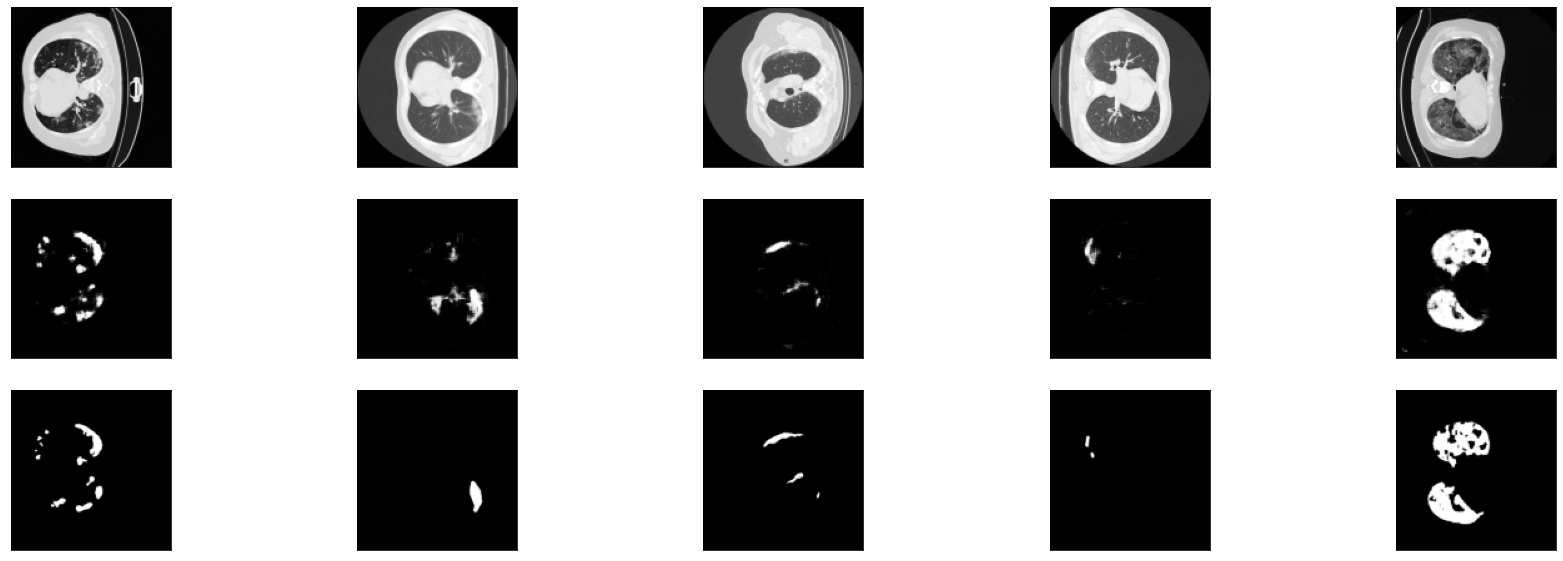

In [22]:
decoded_img = autoencoder.predict(x_test)

n=5
plt.figure(figsize=(30,10))
for i in range (1,n+1):

    #display original (CT)
    ax= plt.subplot(3,n,i)
    plt.imshow(x_test[i].reshape(mysize,mysize))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #display prediction
    ax1=plt.subplot(3,n,i+n)
    plt.imshow(decoded_img[i].reshape(mysize,mysize))
    plt.gray()
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    #display contour (GT)
    ax2=plt.subplot(3,n,i+2*n)
    plt.imshow(y_test[i].reshape(mysize,mysize))
    plt.gray()
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)


plt.show()






Produce graph to show training loss for test and training data as number of epochs increase...

In [23]:
#code to save prediction images as png file
for i in range (len(decoded_img)):
    Prediction=(decoded_img[i].reshape(mysize,mysize))
    predict_name = "/content/drive/MyDrive/Colab Notebooks/ADID-UNET/PredictionResults2022/AE-CNN Normal (800)/Test_Image_"+str(i+1)+"_Predict.png"
    plt.imsave(predict_name,Prediction)
    

In [24]:
#code to save Ground truth (original mask) as png
for i in range (len(decoded_img)):
    GroundTruth=(y_test[i].reshape(mysize,mysize))
    GT = "/content/drive/MyDrive/Colab Notebooks/ADID-UNET/GT/AE-CNN Normal GT (800)/Test_Image_"+str(i+1)+"_OriginalMask.png"
    plt.imsave(GT,GroundTruth)